In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import logging
from models import *

from dataset_reader import dataset_loader
import argparse
import os
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

# Create the argument parser
parser = argparse.ArgumentParser(description="ASVspoof2021 baseline system")

# Dataset
parser.add_argument(
    "--database_path",
    type=str,
    default="/mnt/c/Users/gabri/Desktop/avs/DF/",
    help="Change this to user's full directory address of LA database (ASVspoof2019- for training & development (used as validation), ASVspoof2021 for evaluation scores). We assume that all three ASVspoof 2019 LA train, LA dev, and ASVspoof2021 LA eval data folders are in the same database_path directory.",
)
parser.add_argument(
    "--protocols_path",
    type=str,
    default="/mnt/c/Users/gabri/Desktop/avs/protocols_path/",
    help="Change with path to user's LA database protocols directory address",
)


parser.add_argument(
    "--track", type=str, default="LA", choices=["LA", "PA", "DF"], help="LA/PA/DF"
)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--model_path", type=str, default=None, help="Model checkpoint")

args = parser.parse_args("--track LA --model_path models/model_vae_new_test/epoch_83.pth".split())

In [5]:

track = args.track
# database
prefix = "ASVspoof_{}".format(track)
prefix_2019 = "ASVspoof2019.{}".format(track)

# define train dataloader
d_label_trn, file_train = dataset_loader.genSpoof_list(
    dir_meta=os.path.join(
        args.protocols_path
        + "{}_cm_protocols/{}.cm.train.trn.txt".format(prefix, prefix_2019)
    ),
    is_train=True,
    is_eval=False,
)

print("no. of training trials", len(file_train))

train_set = dataset_loader.Dataset_ASVspoof2019_train(
    args,
    list_IDs=file_train,
    labels=d_label_trn,
    base_dir=os.path.join(
        args.database_path
        + "{}_{}_train/".format(prefix_2019.split(".")[0], args.track)
    ),
    algo=0,
    ae=True,
)

train_loader = DataLoader(
    train_set, batch_size=args.batch_size, num_workers=0, shuffle=True, drop_last=True
)

del train_set, d_label_trn


# define validation dataloader

d_label_dev, file_dev = dataset_loader.genSpoof_list(
    dir_meta=os.path.join(
        args.protocols_path
        + "{}_cm_protocols/{}.cm.dev.trl.txt".format(prefix, prefix_2019)
    ),
    is_train=False,
    is_eval=False,
)

print("no. of validation trials", len(file_dev))

dev_set = dataset_loader.Dataset_ASVspoof2019_train(
    args,
    list_IDs=file_dev,
    labels=d_label_dev,
    base_dir=os.path.join(
        args.database_path + "{}_{}_dev/".format(prefix_2019.split(".")[0], args.track)
    ),
    algo=0,
    ae=True,
)
dev_loader = DataLoader(
    dev_set, batch_size=args.batch_size, num_workers=0, shuffle=False
)
del dev_set, d_label_dev

no. of training trials 25380
no. of validation trials 24844


In [6]:

# make experiment reproducible
# set_random_seed(args.seed, args)

# define model saving path
model_tag = "model_vae_bce_sum_float"
model_save_path = os.path.join("models", model_tag)

# set model save directory
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# GPU device
device = "cpu"#"cuda" if torch.cuda.is_available() else "cpu"
print("Device: {}".format(device))

model = VAE(image_channels=1, device=device).to(device)

if args.model_path:
    model.load_state_dict(torch.load(args.model_path, map_location=device))
    print("Model loaded : {}".format(args.model_path))

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("nb_params:", nb_params)

model.eval()

Device: cpu
Model loaded : models/model_vae_new_test/epoch_83.pth
nb_params: 54332481


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
    (9): ReLU()
    (10): Flatten()
  )
  (fc1): Linear(in_features=5120, out_features=512, bias=True)
  (fc2): Linear(in_features=5120, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=5120, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(5120, 512, kernel_size=(3, 5), stride=(2, 2), dilation=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), dilation=(1, 2))
    (4): ReLU()
    (5): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), dilation=(1, 2))
    (6): ReLU()
    (7): ConvTranspose

In [15]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(8, 1, 128, 253)
        x = x.to(device)
        
        x_hat, _, _ = model(x)

        break

In [16]:
#F.mse_loss(batch_out, batch_x, reduction="sum")/256

In [17]:
from matplotlib import pyplot as plt

In [14]:
def show_image(x, idx):
    x = x.view(batch_size, 128, 253)

    fig = plt.figure()
    sample = x[idx].cpu().numpy()
    plt.imshow(sample)
    return sample


In [19]:
batch_size = 8

0.24705546

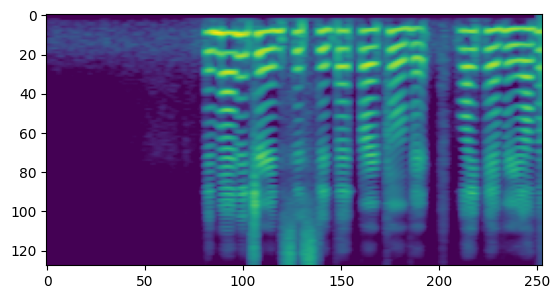

In [20]:
x = show_image(x, 0)
x.mean()

0.2537506

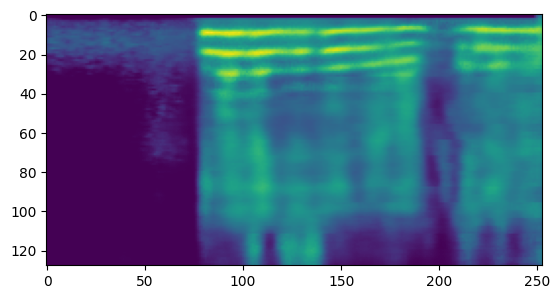

In [21]:
x_hat = show_image(x_hat, 0)
x_hat.mean()

In [14]:
x.max(), x.min(), x_hat.max(), x_hat.min()

(1.0, 0.0, 0.89162415, 2.0082869e-09)

## draft

In [ ]:
idx, (spec, _) = next(enumerate(train_loader))
batch_size = 8
show_image(spec, 0)

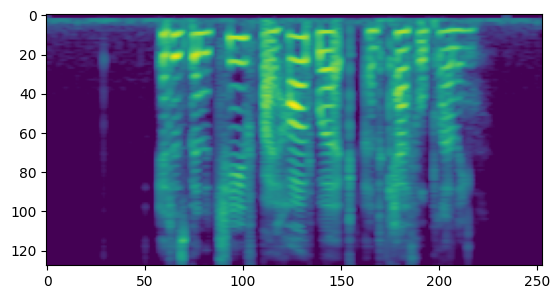

In [18]:
x = spec.view(batch_size, 128, 253)
fig = plt.figure()
sample = x[0].cpu().numpy()
plt.imshow(sample)

In [47]:

track = args.track
# database
prefix = "ASVspoof_{}".format(track)
prefix_2019 = "ASVspoof2019.{}".format(track)

# define train dataloader
d_label_trn, file_train = dataset_loader.genSpoof_list(
    dir_meta=os.path.join(
        args.protocols_path
        + "{}_cm_protocols/{}.cm.train.trn.txt".format(prefix, prefix_2019)
    ),
    is_train=True,
    is_eval=False,
)

print("no. of training trials", len(file_train))

train_set = dataset_loader.Dataset_ASVspoof2019_train(
    args,
    list_IDs=file_train,
    labels=d_label_trn,
    base_dir=os.path.join(
        args.database_path
        + "{}_{}_train/".format(prefix_2019.split(".")[0], args.track)
    ),
    algo=0,
)

train_loader = DataLoader(
    train_set, batch_size=args.batch_size, num_workers=2, shuffle=True, drop_last=True
)

del train_set, d_label_trn

no. of training trials 25380


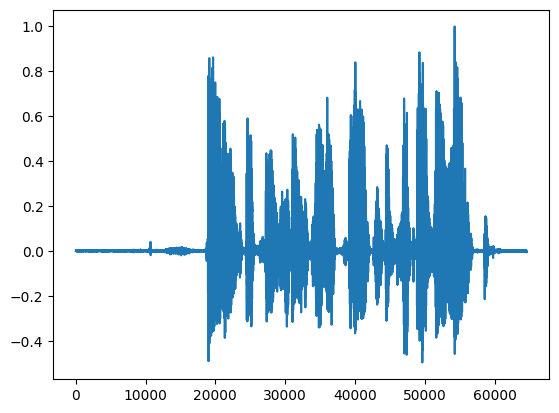

In [50]:
idx, (waves, _) = next(enumerate(train_loader))
batch_size = 64
x = waves.view(batch_size, 64600)
fig = plt.figure()
wave = x[8].cpu().numpy()
plt.plot(wave)

In [51]:
_

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

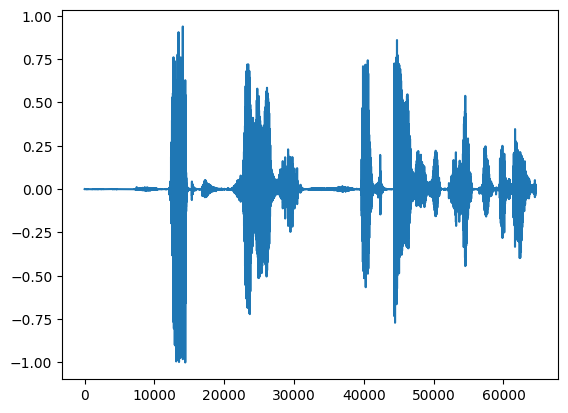

In [56]:
wave = x[-5].cpu().numpy()
plt.plot(wave)

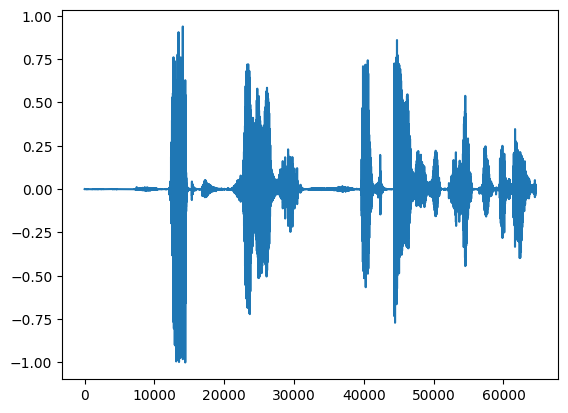

In [57]:
plt.plot(wave)

In [72]:
from torchaudio.functional import highpass_biquad

noise_audio = highpass_biquad(Tensor(wave), sample_rate=16000, cutoff_freq=7e2)
plt.plot(noise_audio)

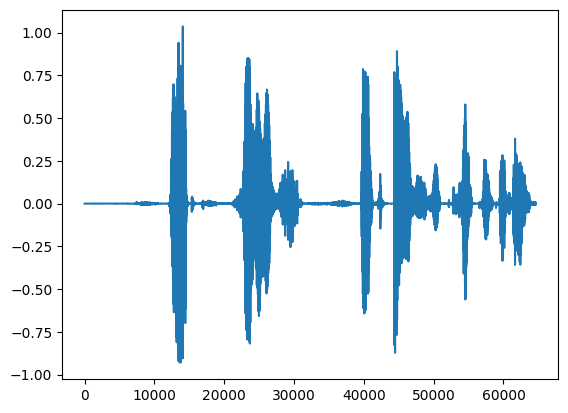

In [ ]:
plt.plot(wave-noise_audio.numpy())

In [ ]:
import soundfile as sf
sf.write('noise.flac', noise_audio, 16000)
sf.write('wave.flac', wave, 16000)
sf.write('subtraction.flac', wave-noise_audio.numpy(), 16000)

In [ ]:
import librosa
import numpy as np
def mel_spec(x):
    S = librosa.feature.melspectrogram(
        y=x,
        sr=16e3,
        n_fft=2048,
        hop_length=256,
        n_mels=128,
    )
    # melspectrogram has raised np.abs(S)**power, default power=2
    # so power_to_db is directly applicable
    S = librosa.core.power_to_db(S, ref=np.max)
    return S

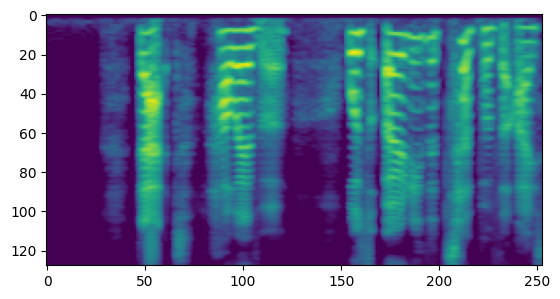

In [ ]:
plt.imshow(mel_spec(wave))

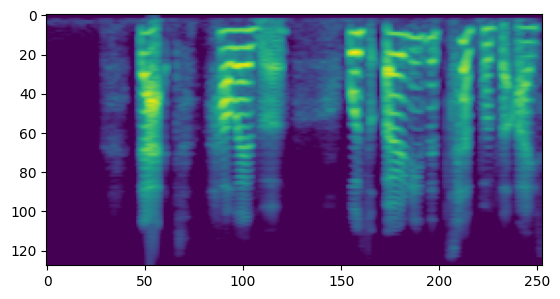

In [ ]:
plt.imshow(mel_spec(wave-noise_audio.numpy()))

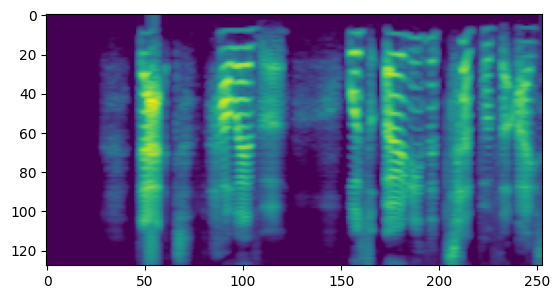

In [ ]:
plt.imshow(mel_spec(noise_audio.numpy()))